# Compare model performance


**Context**


# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import pmdarima as pm

# Scaling the data
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# from scipy import stats

# Create RNN model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError

# Model selection
from sklearn.model_selection import TimeSeriesSplit

# Loading stock data (stored locally)

In [2]:
def load_stock_data_locally(path:str) -> pd.DataFrame:
    '''
    This function receives a path (string) indicating where the stock data is stored locally.
    - It loads the stock data as csv file.
    - It takes Date column as index.
    - It transforms the index into Date time index.
    It returns it as a Pandas Dataframe.
    '''
    stock = pd.read_csv(path, index_col='Date')
    stock.index = pd.to_datetime(stock.index)
    return stock

In [3]:
# Retrieve stock data based on ticker and store it locally
ticker='AAPL'
path_ticker = f"../data/raw_data/{ticker}.csv"

df = load_stock_data_locally(path_ticker)
df.head()

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2023-02-14,151.670441,152.234757,149.353807,150.601222,61707600
2023-02-15,153.779190,153.947491,151.353654,151.581353,65573800
2023-02-16,152.175339,154.769175,151.818932,151.977323,68167900
2023-02-17,151.026932,151.472436,149.343908,150.828932,59144100
2023-02-21,146.997559,149.789411,146.928265,148.700387,58867200


# Train and test split



In [4]:
def get_split_data(df:pd.DataFrame, train_size : float):
    '''
    This function gets a Pandas Dataframe and an float that represents 
    the size of my train dataset relative to all the available data.
    It return a train dataset and a test dataset.
    '''
    index= round(train_size*df.shape[0])
    train = df.iloc[:index]
    test = df.iloc[index:]
    return train, test

In [5]:
def plot_train_test_df(train:pd.DataFrame, test:pd.DataFrame):
    '''
    This function receives 2 Pandas Dataframes: train and test.
    - It selects the numerical features in the input dataframes.
    - It plots lineplots for each numerical feature of the 2 input dataframes.
    '''     
    # Numerical Features
    numerical_features = train.select_dtypes(include = 'number').columns.values.tolist()

    #Parameters     
    ncol_max = 1
    nrow_max = len(numerical_features)   
    
    #Figure settings
    fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(8, 15))

    # Flatten axes for easy iteration
    axs = axs.flatten()
    
    for index, col in enumerate(numerical_features):  
        # Plotting the histograms
        sns.lineplot(data = train[numerical_features], y= col, x=train.index,  ax=axs[index])   
        sns.lineplot(data = test[numerical_features], y= col, x=test.index,  ax=axs[index])  
        
        # Formatting
        axs[index].set_xlabel(col)
        axs[index].set_title(f'Line Plot - {col}')  
        axs[index].legend(["Train set", "Test set"], title="Legend", loc="best")
        
        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.8)  # wspace (width), hspace (height)    

In [6]:
def plot_lines_series_train_test(train:pd.DataFrame, test:pd.DataFrame, target):
    '''
    This function receives 2 Pandas Dataframes: train and test, and a target feature.
    - It plots lineplots for each numerical feature of the 2 input dataframes.
    '''      
    #Figure settings
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plotting the histograms
    sns.lineplot(data=train, x=train.index, y=target)  
    sns.lineplot(data=test, x=test.index, y=target)  
    
    # Formatting  
    ax.set_xlabel(f"{target}")
    ax.set_title(f'Line Plot - {target}')  
    ax.legend(["Train set", "Test set"], title="Legend", loc="best")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.8)  # wspace (width), hspace (height)     

In [7]:
# Get the train set and the test set
train, test = get_split_data(df, train_size = 0.8)  

print(f"train set shape : {train.shape}")
print(f"test set shape : {test.shape}")

train set shape : (402, 5)
test set shape : (101, 5)


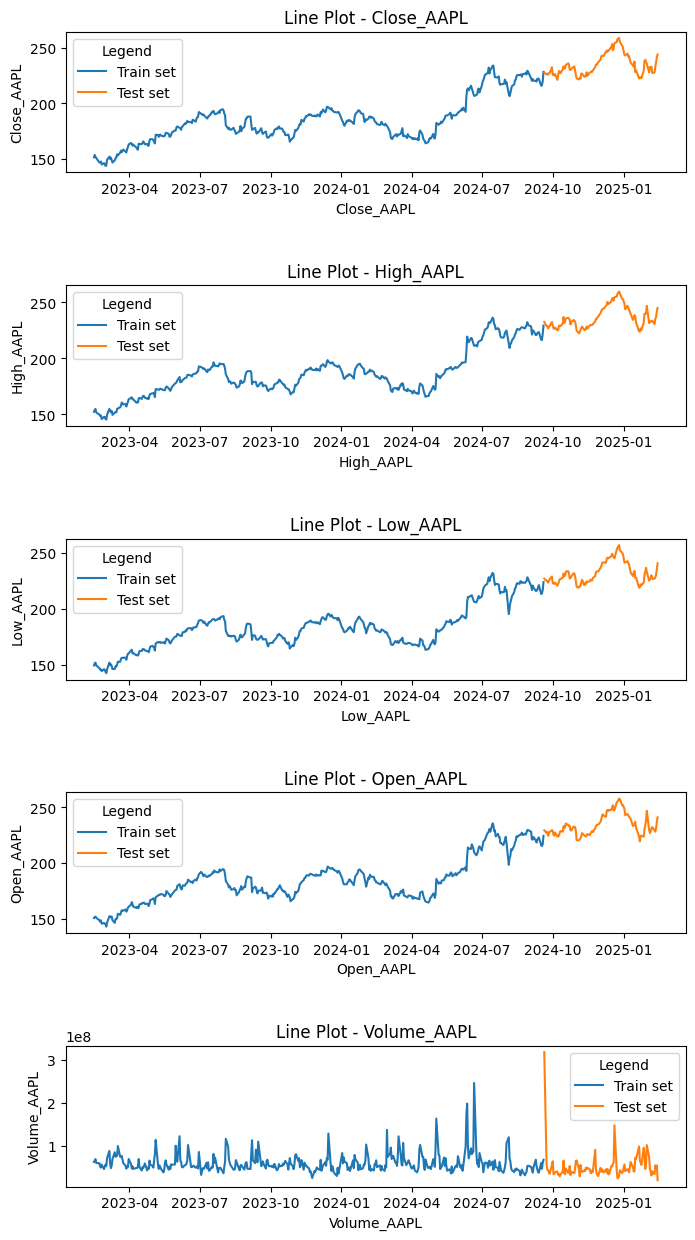

In [8]:
# Plot the train set and the test set
plot_train_test_df(train, test)

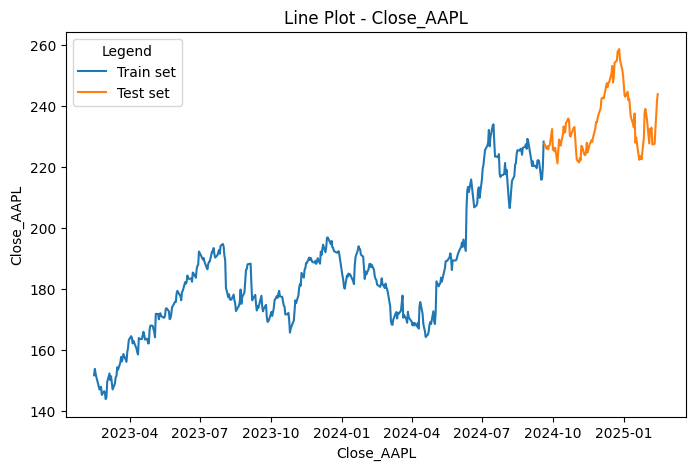

In [9]:
# Plot the train set and the test set (only plot the target feature)
target = f"Close_{ticker}"
plot_lines_series_train_test(train,test, target)  


# LSTM model


## One feature


### Data preparation


In [10]:
def prepare_train_data(df, target: list, scaler, look_back=10):
    '''
    This function receives a Pandas dataframe, a target list, a scaler and a observation window parameter.
    - It scales the train data, then create sequences of train data.
    Outputs : training data X, training target y and fitted scaler
    '''
    scaled_data = scaler.fit_transform(df[target])    
    X, y = [], []
    for i in range(look_back, len(scaled_data)-1):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i])       
    return np.array(X), np.array(y), scaler

In [11]:
def prepare_test_data(df, target: list, scaler=None, look_back=10):
    '''
    This function receives a Pandas dataframe, a target list, a scaler and a observation window parameter.
    Scales the test data, then create sequences of test data.
    Outputs : test data X, test target y and associated dates
    '''
    scaled_data = scaler.transform(df[target])
    X, y = [], []
    dates = []
    for i in range(look_back, len(scaled_data)-1):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i])   
        dates.append(df.index[i])
    return np.array(X), np.array(y), dates

In [12]:
target = [f"Close_{ticker}"]

scaler = MinMaxScaler()
look_back = 60

X_train_scaled, y_train_scaled, std_scaler = prepare_train_data(train, target, scaler, look_back)
print(f"X_train_scaled shape : {X_train_scaled.shape}")
print(f"y_train_scaled shape : {y_train_scaled.shape}")

X_train_scaled shape : (341, 60, 1)
y_train_scaled shape : (341, 1)


In [13]:
X_test_scaled, y_test_scaled, test_dates = prepare_test_data(test, target, scaler, look_back)
print(f"X_test_scaled shape : {X_test_scaled.shape}")
print(f"y_test_scaled shape : {y_test_scaled.shape}")

X_test_scaled shape : (40, 60, 1)
y_test_scaled shape : (40, 1)


### Model creation


In [14]:
# # Create LSTM model architecture
# def define_LSTM_model(sequence, feature):
#     '''
#     Defines the structure of the deep learning model, then defines compilation parameters.
#     Outputs LSTM model instance.
#     '''
#     # 1- RNN Architecture
#     model = Sequential()
#     model.add(layers.LSTM(units=500, activation='tanh',
#                           input_shape=(sequence,feature)))
#     model.add(layers.Dropout(rate=0.2))
#     model.add(layers.Dense(1, activation="linear"))

#     # 2- Compilation
#     model.compile(loss='mse', optimizer='adam', 
#                   metrics =['mse', 'mae', RootMeanSquaredError(), MeanAbsolutePercentageError()])
#     return model

In [15]:
# # Create LSTM model architecture
# def define_LSTM_model(sequence, feature):
#     '''
#     Defines the structure of the deep learning model, then defines compilation parameters.
#     Outputs LSTM model instance.
#     '''
#     # 1- RNN Architecture
#     model = Sequential()
#     model.add(layers.LSTM(units=100, activation='tanh',return_sequences=True, input_shape=(sequence,feature)))
#     model.add(layers.Dropout(rate=0.2))
#     model.add(layers.LSTM(units=50, activation='tanh',return_sequences=False))
#     model.add(layers.Dropout(rate=0.2))
#     model.add(layers.Dense(1, activation="linear"))

#     # 2- Compilation
#     model.compile(loss='mse', optimizer='adam', 
#                   metrics =['mse', 'mae', RootMeanSquaredError(), MeanAbsolutePercentageError()])
#     return model

In [16]:
# Create LSTM model architecture
def define_LSTM_model(sequence, feature):
    '''
    Defines the structure of the deep learning model, then defines compilation parameters.
    Outputs LSTM model instance.
    '''
    # 1- RNN Architecture
    model = Sequential()
    model.add(layers.LSTM(units=50, activation='tanh',return_sequences=True, input_shape=(sequence,feature)))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.LSTM(units=20, activation='tanh',return_sequences=False))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation="linear"))

    # 2- Compilation
    model.compile(loss='mse', optimizer='adam', 
                  metrics =['mse', 'mae', RootMeanSquaredError(), MeanAbsolutePercentageError()])
    return model

### Visualization

In [17]:
def plot_final_lstm(train, train_label,
                   test, test_label,
                   forecast_recons, forecast_recons_label,
                   target):
    '''
    Plots the training data, the test data and the predictions from LSTM model.
    Outputs : All the data on left side, a zoomed plot on latest data on the right side.
    '''
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(train, label=train_label)
    axs[0].plot(test, label=test_label)
    axs[0].plot(forecast_recons, label=forecast_recons_label)
    axs[0].legend()
    axs[0].set_title('Train data, test data and predictions')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel(f"{target[0]}")

    n_last =100
    axs[1].plot(train[-n_last:], label=train_label)
    axs[1].plot(test, label=test_label)
    axs[1].plot(forecast_recons, label=forecast_recons_label)
    axs[1].legend()
    axs[1].set_title('ZOOM on train data, test data and predictions')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel(f"{target[0]}")

### Cross validation


In [18]:
# Parameters 
cv = 5
window = 1 # Unit : day
nb_feature = len(target)

#Create model     
lstm_model = define_LSTM_model(window, nb_feature)

3/3 [==============================] - 0s 2ms/step
Evaluation metric results:-
MSE for LSTM model (1 feature) is : 14.432724276860515
MAE for LSTM model (1 feature) is : 2.956626797899786
RMSE for LSTM model (1 feature) is : 3.6601098464865474
MAPE for LSTM model (1 feature) is : 0.01428587005289172
CPU times: user 38.2 s, sys: 12.1 s, total: 50.4 s
Wall time: 34 s


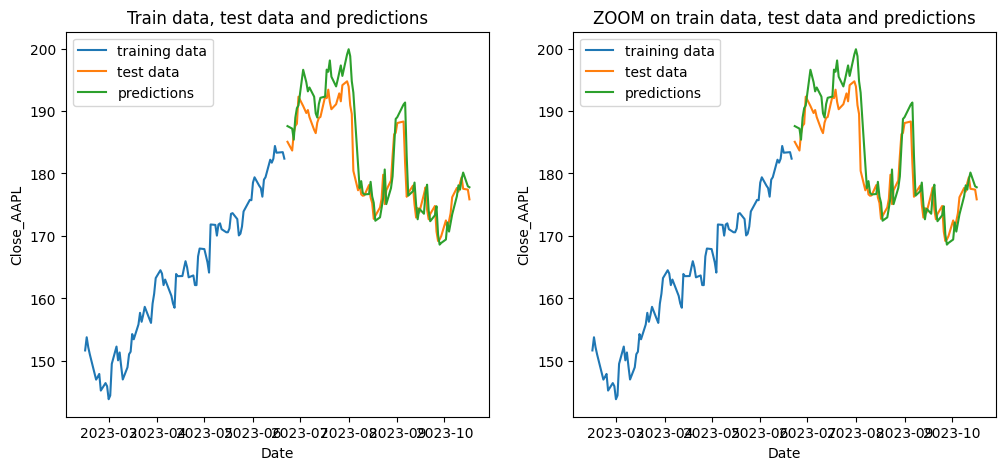

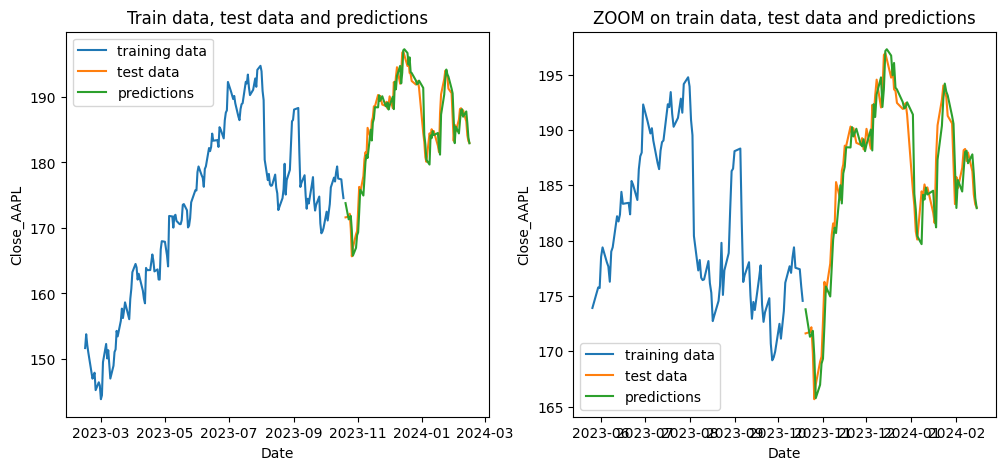

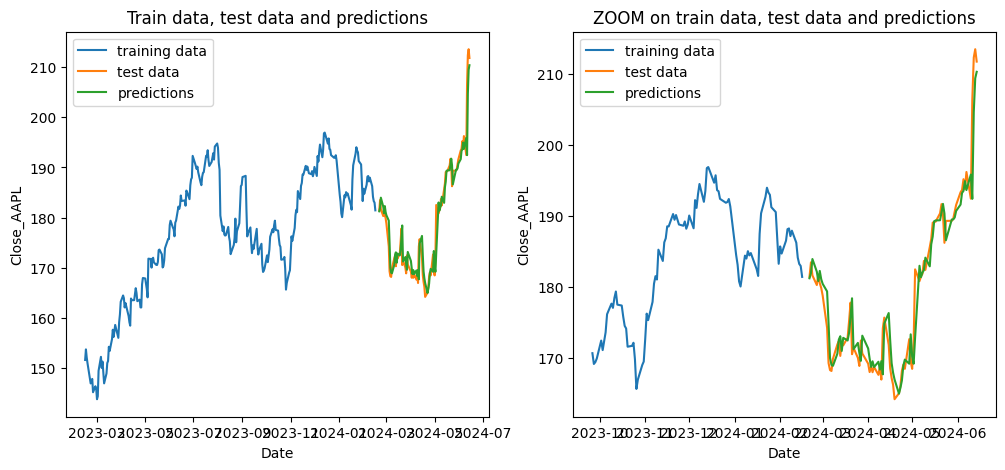

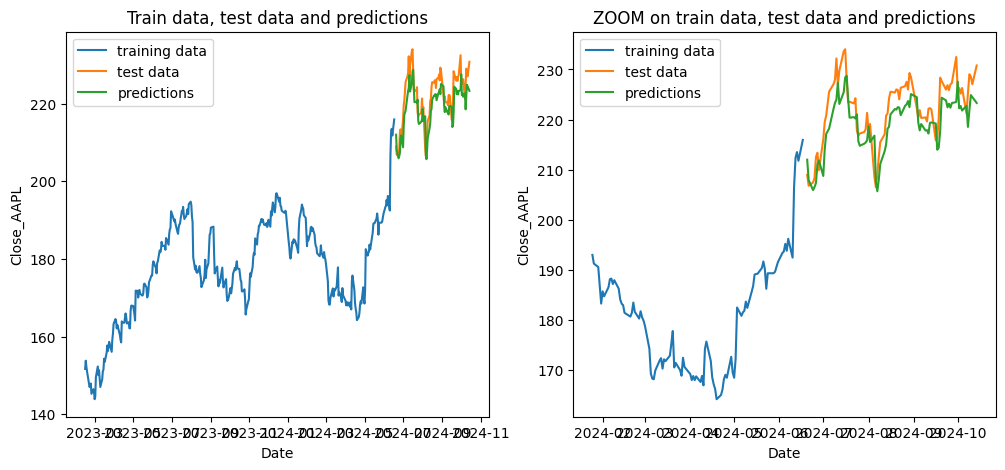

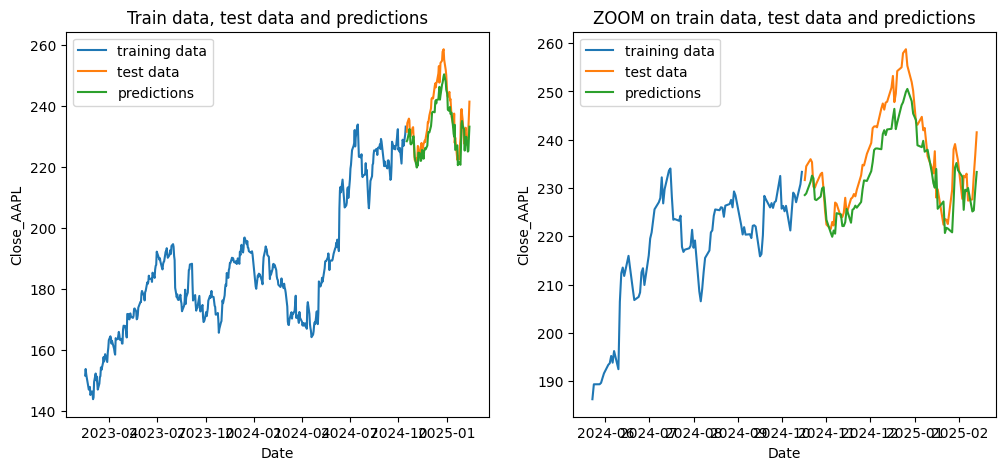

In [19]:
%%time 

# Time Series Cross-Validation Setup
tscv = TimeSeriesSplit(n_splits=cv)

mse_lstm_1_feat, mae_lstm_1_feat, rmse_lstm_1_feat, mape_lstm_1_feat = [],[],[],[]

for train_index, test_index in tscv.split(df):
    '''
    Cross validates the LSTM model.
    1. Create train dataset and test dataset
    2. Prepare train data and test data (scaling, sequences)
    3. Fit the LSTM model on the train (scaled) data
    4. Predict unseen data (i.e based on test set)
    5. Inverse scaling of scaled test and also predictions
    6. Compute metrics
    7. Plots the training data, the test data and the predictions from LSTM model and outputs : All the data on left side, a zoomed plot on latest data on the right side.
    '''
    
    #Create train set and test set     
    train_cv, test_cv = df[target].iloc[train_index], df[target].iloc[test_index]
        
    #Prepare data
    scaler = MinMaxScaler() 
    X_train_scaled, y_train_scaled, fitted_scaler = prepare_train_data(train_cv, target, scaler, window)
    X_test_scaled, y_test_scaled, dates = prepare_test_data(test_cv, target, fitted_scaler, window)
    
    # Fitting model parameter
    es = EarlyStopping(patience = 30, restore_best_weights=True)

    # Fitting model
    history = lstm_model.fit(x=X_train_scaled,
                        y=y_train_scaled,
                        batch_size=16,
                        epochs=1000,
                        verbose=0,
                        callbacks=[es],
                        validation_split=0.3,
                        shuffle=False)
    
    # Predictions from unseen data
    y_pred = lstm_model.predict(X_test_scaled)
    y_pred = scaler.inverse_transform(y_pred)   
    y_pred_df = pd.DataFrame(y_pred, index=dates)

    # Compute y_test (no scaling)
    y_test = scaler.inverse_transform(y_test_scaled)
    y_test_df = pd.DataFrame(y_test, index=dates)

    # Compute metrics     
    mse_lstm_1_feat.append(mean_squared_error(y_test_df, y_pred_df))
    mae_lstm_1_feat.append(mean_absolute_error(y_test_df, y_pred_df))
    rmse_lstm_1_feat.append(np.sqrt(mean_squared_error(y_test_df, y_pred_df)))
    mape_lstm_1_feat.append(mean_absolute_percentage_error(y_test_df,y_pred_df))
    
    # Plotting     
    plot_final_lstm(train_cv, "training data",
                   y_test_df, "test data",
                   y_pred_df, "predictions",
                   target)

# Compute the metrics mean
mse_lstm_mean_1_feat = np.mean(mse_lstm_1_feat)
mae_lstm_mean_1_feat = np.mean(mae_lstm_1_feat)
rmse_lstm_mean_1_feat = np.mean(rmse_lstm_1_feat)
mape_lstm_mean_1_feat = np.mean(mape_lstm_1_feat)

print('Evaluation metric results:-')
print(f'MSE for LSTM model (1 feature) is : {mse_lstm_mean_1_feat}')
print(f'MAE for LSTM model (1 feature) is : {mae_lstm_mean_1_feat}')
print(f'RMSE for LSTM model (1 feature) is : {rmse_lstm_mean_1_feat}')
print(f'MAPE for LSTM model (1 feature) is : {mape_lstm_mean_1_feat}')


## Multiple features


### Data preparation

In [20]:
def prepare_train_data_multiple_feats(df, features_list: list, target:str, scaler, target_scaler, look_back=10):
    '''
    This function receives a Pandas dataframe, a features list, a target feature, a scaler and a observation window parameter.
    - It scales the train data, then create sequences of train data.
    Outputs : training data X, training target y and fitted scaler
    '''
    scaled_data = scaler.fit_transform(df[features_list]) 
    scaled_data_df = pd.DataFrame(scaled_data, columns=scaler.get_feature_names_out())
    
    #Scaling target (for prediction inverse transform)
    target_scaler.fit(df[[target]])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data_df)-1):
        X.append(scaled_data_df.iloc[i-look_back:i].to_numpy())
        y.append(scaled_data_df[target].iloc[i])       
    return np.array(X), np.array(y), scaler, target_scaler


In [21]:
def prepare_test_data_multiple_feats(df, features_list: list, target:str, scaler, look_back=10):
    '''
    This function receives a Pandas dataframe, a target list, a scaler and a observation window parameter.
    Scales the test data, then create sequences of test data.
    Outputs : test data X, test target y and associated dates
    '''
    scaled_data = scaler.transform(df[features_list])
    scaled_data_df = pd.DataFrame(scaled_data, columns=scaler.get_feature_names_out())
    
    X, y = [], []
    dates = []
    for i in range(look_back, len(scaled_data_df)-1):
        X.append(scaled_data_df.iloc[i-look_back:i].to_numpy())
        y.append(scaled_data_df[target].iloc[i]) 
        dates.append(df.index[i])
    return np.array(X), np.array(y), dates

In [22]:
features_list = df.columns.to_list()
target = f"Close_{ticker}"
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
look_back = 1

X_train_scaled, y_train_scaled, fitted_scaler, fitted_target_scaler = prepare_train_data_multiple_feats(train, 
                                                                               features_list,
                                                                               target, 
                                                                               scaler, 
                                                                               target_scaler, 
                                                                               look_back)
print(f"X_train_scaled shape : {X_train_scaled.shape}")
print(f"y_train_scaled shape : {y_train_scaled.shape}")

X_train_scaled shape : (400, 1, 5)
y_train_scaled shape : (400,)


In [23]:
X_test_scaled, y_test_scaled, test_dates = prepare_test_data_multiple_feats(test,features_list, target, scaler, look_back)
print(f"X_test_scaled shape : {X_test_scaled.shape}")
print(f"y_test_scaled shape : {y_test_scaled.shape}")

X_test_scaled shape : (99, 1, 5)
y_test_scaled shape : (99,)


### Cross validation


In [24]:
# Parameters 
features_list = df.columns.to_list()
window = 1 # Unit : day
nb_feature = len(features_list)

#Create model     
lstm_model = define_LSTM_model(window, nb_feature)


In [ ]:
%%time 

# Time Series Cross-Validation Setup
tscv = TimeSeriesSplit(n_splits=cv)

mse_lstm_mul_feat, mae_lstm_mul_feat, rmse_lstm_mul_feat, mape_lstm_mul_feat = [],[],[],[]

for train_index, test_index in tscv.split(df):
    '''
    Cross validates the LSTM model.
    1. Create train dataset and test dataset
    2. Prepare train data and test data (scaling, sequences)
    3. Fit the LSTM model on the train (scaled) data
    4. Predict unseen data (i.e based on test set)
    5. Inverse scaling of scaled test and also predictions
    6. Compute metrics
    7. Plots the training data, the test data and the predictions from LSTM model and outputs : All the data on left side, a zoomed plot on latest data on the right side.
    '''
    
    #Create train set and test set     
    train_cv, test_cv = df[features_list].iloc[train_index], df[features_list].iloc[test_index]
        
    #Prepare data
    scaler = MinMaxScaler()   
    target_scaler = MinMaxScaler()
    
    X_train_scaled, y_train_scaled, \
    fitted_scaler, fitted_target_scaler = prepare_train_data_multiple_feats(train_cv, features_list,
                                                                            target, scaler, target_scaler, window)
    
    X_test_scaled, y_test_scaled, dates = prepare_test_data_multiple_feats(test_cv,features_list,
                                                                           target, fitted_scaler, window)
    
    # Fitting model parameter
    es = EarlyStopping(patience = 30, restore_best_weights=True)

    # Fitting model
    history = lstm_model.fit(x=X_train_scaled,
                        y=y_train_scaled,
                        batch_size=16,
                        epochs=1000,
                        verbose=0,
                        callbacks=[es],
                        validation_split=0.3,
                        shuffle=False)
    
    # Predictions from unseen data
    y_pred = lstm_model.predict(X_test_scaled)
    y_pred = fitted_target_scaler.inverse_transform(y_pred)   
    y_pred_df = pd.DataFrame(y_pred, index=dates)

    # Compute y_test (no scaling)
    y_test_scaled = y_test_scaled.reshape(-1,1)
    y_test = fitted_target_scaler.inverse_transform(y_test_scaled)
    y_test_df = pd.DataFrame(y_test, index=dates)

    # Compute metrics     
    mse_lstm_mul_feat.append(mean_squared_error(y_test_df, y_pred_df))
    mae_lstm_mul_feat.append(mean_absolute_error(y_test_df, y_pred_df))
    rmse_lstm_mul_feat.append(np.sqrt(mean_squared_error(y_test_df, y_pred_df)))
    mape_lstm_mul_feat.append(mean_absolute_percentage_error(y_test_df,y_pred_df))
    
    # Plotting     
    plot_final_lstm(train_cv[target], "training data",
                   y_test_df, "test data",
                   y_pred_df, "predictions",
                   target)
    
# Compute the metrics mean
mse_lstm_mean_mul_feat = np.mean(mse_lstm_mul_feat)
mae_lstm_mean_mul_feat = np.mean(mae_lstm_mul_feat)
rmse_lstm_mean_mul_feat = np.mean(rmse_lstm_mul_feat)
mape_lstm_mean_mul_feat = np.mean(mape_lstm_mul_feat)

print('Evaluation metric results:-')
print(f'MSE for LSTM model (multiple features) is : {mse_lstm_mean_mul_feat}')
print(f'MAE for LSTM model (multiple features) is : {mae_lstm_mean_mul_feat}')
print(f'RMSE for LSTM model (multiple features) is : {rmse_lstm_mean_mul_feat}')
print(f'MAPE for LSTM model (multiple features) is : {mape_lstm_mean_mul_feat}')   

3/3 [==============================] - 0s 2ms/step


## Comparison


In [ ]:
compar = {}
compar['Model'] = ['LSTM_1_feat', 'LSTM_mul_feat']
compar['Mean MSE'] = [mse_lstm_mean_1_feat, mse_lstm_mean_mul_feat]
compar['Mean MAE'] = [mae_lstm_mean_1_feat, mae_lstm_mean_mul_feat]
compar['Mean RMSE'] = [rmse_lstm_mean_1_feat, rmse_lstm_mean_mul_feat]
compar['Mean MAPE'] = [mape_lstm_mean_1_feat, mape_lstm_mean_mul_feat]

compar_df = pd.DataFrame(compar).sort_values('Mean MAPE', ascending=True)
compar_df